In [255]:
import numpy as np
from numpy.linalg import norm, solve
from icosphere import icosphere
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

class FEMSphereSolver:
    def __init__(self, radius=1, epsilon=1e-8):
        self.radius = radius
        self.epsilon = epsilon
        self.vertices = None
        self.faces = None
        self.S = None
        self.M = None

    def generate_mesh(self, nu):
        self.vertices, self.faces = icosphere(nu)
        return self.vertices, self.faces

    ### Define local stiff and local math
    def compute_local_stiffness(self, r1, r2, r3):
        E1 = r2 - r3
        E2 = r3 - r1
        E3 = r1 - r2
        cross = np.cross(E1, E2)
        A = 0.5*norm(cross)
        S_loc = np.array(([np.dot(E1, E1), np.dot(E1, E2), np.dot(E1, E3)], 
                      [np.dot(E2, E1), np.dot(E2, E2), np.dot(E2, E3)], 
                      [np.dot(E3, E2), np.dot(E3, E2), np.dot(E3, E3)]))
        S_k = (1/(4*A))*S_loc
        return S_k

    def compute_local_mass(self, r1, r2, r3):
        E1 = r2 - r3
        E2 = r3 - r1
        E3 = r1 - r2
        crossin = np.cross(E1, E2)
        A = 0.5*norm(crossin)
        M_k = (A/12)*np.array(([2, 1, 1], [1, 2, 1], [1, 1, 2]))
        return M_k

    def compute_global_matrices(self):
        # Placeholder for your implementation
        Nv = self.vertices.shape[0]
        self.S = np.zeros((Nv, Nv))
        self.M = np.zeros((Nv, Nv))

        for tri in self.faces:
            k1, k2, k3 = tri
            r1, r2, r3 = self.vertices[k1], self.vertices[k2], self.vertices[k3]

            local_stiffness = self.compute_local_stiffness(r1, r2, r3)
            local_mass = self.compute_local_mass(r1, r2, r3)

            for i, vertex_i in enumerate(tri):
                for j, vertex_j in enumerate(tri):
                    self.S[vertex_i, vertex_j] += local_stiffness[i, j]
                    self.M[vertex_i, vertex_j] += local_mass[i, j]

        return self.S, self.M


    def solve_system(self):
        phi, theta, _ = self.cart2sph(self.vertices[:, 0], self.vertices[:, 1], self.vertices[:, 2])
        theta = theta + np.pi / 2
        u_ex_i = self.u_ex(theta, phi)
        f_i = self.f(theta, phi)

        S_eps = self.S + self.epsilon * np.identity(len(self.S))
        u_fem, _, _, _ = np.linalg.lstsq(S_eps, np.matmul(self.M, f_i), rcond=None)

        error = self.compute_error(u_ex_i, u_fem)
        return u_fem

    def cart2sph(self, x, y, z):
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        phi = np.arctan2(y, x)
        theta = np.arctan2(z, hxy)
        return phi, theta, r

    def f(self, theta, phi):
        return -2 * np.cos(theta)

    def u_ex(self, theta, phi):
        u_exact = np.cos(theta)
        return u_exact

    # def compute_error(self, u_exact, u_fem):
    #     return norm(np.matmul(self.M, (u_exact - u_fem)))  # L2 norm
    
    def compute_error(self, u_exact, u_fem):
        error_vector = u_exact - u_fem
        weighted_error = np.dot(error_vector.T, np.dot(self.M, error_vector))
        error = np.sqrt(weighted_error)
        return error
    
    def plot_solution_on_sphere(self, solution):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Extract vertices
        x, y, z = self.vertices[:, 0], self.vertices[:, 1], self.vertices[:, 2]

    # Normalize the solution for color mapping
        solution_normalized = (solution - np.min(solution)) / (np.max(solution) - np.min(solution))

    # Create a colormap
        cmap = plt.get_cmap('viridis')

    # Map the normalized solution to RGBA values using the colormap
        colors = cmap(solution_normalized)

    # Assuming 'self.faces' is an Nx3 array of the triangle vertex indices
    # Create a triangulated surface plot with the colormap
        surf = ax.plot_trisurf(x, y, z, triangles=self.faces, cmap=cmap, linewidth=0.2, antialiased=True)

    # Set the face colors of the plot using the RGBA values
        surf.set_facecolors(colors)

    # Add a color bar
        mappable = plt.cm.ScalarMappable(cmap=cmap)
        mappable.set_array(solution)
        plt.colorbar(mappable, ax=ax, label='Solution Value')

    # Set labels and title
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_title('Solution to the Poisson Equation on a Sphere')

    # Show the plot
        plt.show()

In [245]:
solver = FEMSphereSolver()

errors = []
h_mesh = []
desired_min_N = 0
desired_max_N = 10

for N in range(desired_min_N, desired_max_N + 1):
    solver.generate_mesh(N)
    solver.compute_global_matrices()

    u_fem = solver.solve_system()
    error = solver.compute_error(u_fem, u_exact)
    errors.append(error)
    # Assuming pdist is implemented or an equivalent function
    h_mesh.append(min(pdist(solver.vertices))) 

# errors and h_mesh now contain the error and mesh size for each subdivision level

TypeError: u_ex() missing 2 required positional arguments: 'theta' and 'phi'

c:\Users\Colin\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

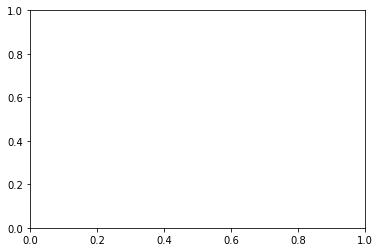

In [242]:
import matplotlib.pyplot as plt

# Assuming 'errors' is a list containing the error for each subdivision level
# and 'subdivision_levels' is a list of the corresponding subdivision levels
subdivision_levels = range(desired_min_N, desired_max_N + 1)
x = np.linspace(0,1,1000)

y = [i**2 for i in h_mesh]
plt.plot(h_mesh, errors, marker='o', color='red', label='FEM')
plt.plot(h_mesh, y, label='The Error is going bonkers')
plt.xlabel('min edge length (h)')
plt.ylabel('Error')
plt.yscale('log')
plt.title('FEM Error at Different Meshes')
plt.legend()
plt.grid(True)
plt.show()

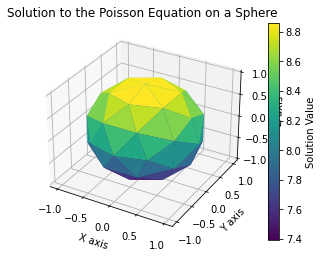

In [256]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

solver = FEMSphereSolver(radius=1)
solver.generate_mesh(nu=2)  # Replace with appropriate mesh resolution
solver.compute_global_matrices()
solution = solver.solve_system()  # Assuming this returns the solution array
solver.plot_solution_on_sphere(solution)


In [209]:
FEM = FEMSphereSolver()

V,faces = FEM.generate_mesh(3)

S, M , tri = FEM.compute_global_matrices()

lap = np.matmul(np.linalg.inv(M), S)

e_val, e_vec = np.linalg.eig(lap)

e_vec_repeated = np.tile(e_vec, 3)

e_vec_abs = np.abs(e_vec)

f = e_vec_abs * V

# f = np.abs(np.tile(e_vec, (1, 3)))

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

C = V
#Create a triangular surface plot
triplot = ax.plot_trisurf(tri, f[:, 0], f[:, 1], f[:, 2], facecolors=C, shade=False, edgecolor='none')

# Set the aspect ratio to be equal
ax.set_box_aspect([1, 1, 1])

# Show the plot
plt.show()

ValueError: operands could not be broadcast together with shapes (92,92) (92,3) 

c:\Users\Colin\AppData\Local\Programs\Python\Python39\lib\site-packages\mpl_toolkits\mplot3d\axes3d.py:2760: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


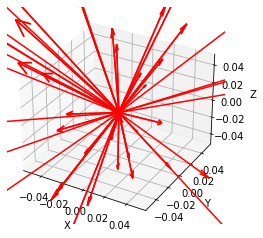

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Calculate eigenvalues and eigenvectors
EM = FEMSphereSolver()

V,faces = FEM.generate_mesh(3)

S, M , tri = FEM.compute_global_matrices()

lap = np.matmul(np.linalg.inv(M), S)

eigenvalues, eigenvectors = np.linalg.eig(lap)

# Step 2: Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot eigenvectors as vectors originating from the origin
origin = np.zeros(3)  # Origin point

for eigenvector in eigenvectors.T:
    ax.quiver(*origin, eigenvector[0], eigenvector[1], eigenvector[2], color='r', pivot='tail', arrow_length_ratio=0.1)


# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


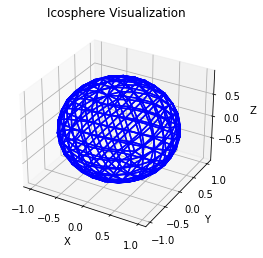

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from icosphere import icosphere

nu = 5
# Generate the icosphere mesh
vertices, faces = icosphere(nu)  # Adjust subdivisions as needed

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting each triangle in the icosphere
for tri in faces:
    triangle = vertices[tri]
    x, y, z = zip(*triangle)
    x += (x[0],)
    y += (y[0],)
    z += (z[0],)
    ax.plot(x, y, z, color='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Icosphere Visualization')
plt.show()